In [1]:
from models.base_network import BaseNetwork, BaseNetwork1, EmbedLayer, FlattenLayer
from file_handling.load_datasets import load_mnist
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.utils

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

from preprocessing.noise_models import gaussian_noise, shot_noise, defocus_blur, zoom_blur, brightness, snow, clipped_zoom

/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Loading Datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 255*x)])
test_data = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
train_data = datasets.CIFAR10(root='./cifar-10', train=True, download=False, transform=transform)

In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=2)

### Initializing Networks

In [72]:
good_model = BaseNetwork1(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        FlattenLayer(),
                        nn.Linear(256, 512), nn.ReLU(),
                        nn.Linear(512, 512), nn.ReLU(),
                        nn.Linear(512, 10))
good_model_opt = optim.RMSprop(good_model.parameters(), lr=0.0005)

In [73]:
good_model

BaseNetwork1(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): FlattenLayer()
  (10): Linear(in_features=256, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU()
  (14): Linear(in_features=512, out_features=10, bias=True)
)

In [5]:
reg_net = BaseNetwork1(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        FlattenLayer(),
                        nn.Linear(256, 5000), nn.ReLU(),
                        nn.Linear(5000, 100), nn.ReLU(),
                        nn.Linear(100, 10))
# reg_net = BaseNetwork("reg_net", [(3, 16, 3),(16,32,3), (32, 64, 3),(256,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "conv", "fc", "fc", "fc"])
# emb_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5), (800,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "fc", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5),(800,100),(100,10)],
#                                 ["conv", "conv", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["fc", "fc", "fc"])
reg_net_opt = optim.RMSprop(reg_net.parameters(), lr=0.0005)

In [6]:
reg_net

BaseNetwork1(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): FlattenLayer()
  (10): Linear(in_features=256, out_features=5000, bias=True)
  (11): ReLU()
  (12): Linear(in_features=5000, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=10, bias=True)
)

In [50]:
emb_net = BaseNetwork1(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        FlattenLayer(),
                        EmbedLayer(256, 5000),
                        nn.Linear(5000, 100), nn.ReLU(),
                        nn.Linear(100, 10))
# emb_net = BaseNetwork("emb_net", [(3, 16, 3),(16,32,3), (32, 64, 3),(256,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "conv", "emb", "fc","fc"])
# emb_net = BaseNetwork("emb_net", [(3, 16, 5),(16,32,5), (800,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "emb", "fc", "fc"])
# emb_net = BaseNetwork("emb_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["emb", "fc", "fc"])
emb_net_opt = optim.RMSprop(emb_net.parameters(), lr=0.000005, momentum=0.9)

In [41]:
emb_net

BaseNetwork1(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): FlattenLayer()
  (10): EmbedLayer()
  (11): Linear(in_features=5000, out_features=100, bias=True)
  (12): ReLU()
  (13): Linear(in_features=100, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()

### Training, Saving and Loading Models

In [74]:
good_model.train_model(train_loader, 5, good_model_opt, criterion)

Training Model


[1,    16] loss: 3.44710
[1,    32] loss: 2.21299
[1,    48] loss: 2.18783
[1,    64] loss: 2.12635
[1,    80] loss: 2.09354
[1,    96] loss: 2.02652
[1,   112] loss: 1.96318
[1,   128] loss: 2.01699
[1,   144] loss: 1.99464
[1,   160] loss: 1.86340
[1,   176] loss: 1.96795
[1,   192] loss: 1.82219
[1,   208] loss: 1.95631
[1,   224] loss: 1.85424
[1,   240] loss: 1.79705
[1,   256] loss: 1.84122
[1,   272] loss: 1.86156
[1,   288] loss: 1.75173
[1,   304] loss: 1.75333
[1,   320] loss: 1.83024
[1,   336] loss: 1.77603
[1,   352] loss: 1.65796
[1,   368] loss: 1.75553
[1,   384] loss: 1.72256
[1,   400] loss: 1.70033
[1,   416] loss: 1.73855
[1,   432] loss: 1.76149
[1,   448] loss: 1.66079
[1,   464] loss: 1.67132
[1,   480] loss: 1.72578
[1,   496] loss: 1.71452
[1,   512] loss: 1.71194
[1,   528] loss: 1.60895
[1,   544] loss: 1.62146
[1,   560] loss: 1.73926
[1,   576] loss: 1.75148
[1,   592] loss: 1.65157
[1,   608] loss: 1.66449
[1,   624] loss: 1.61424
[1,   640] loss: 1.73460


[2,    16] loss: 1.25735
[2,    32] loss: 1.30549
[2,    48] loss: 1.37439
[2,    64] loss: 1.32371
[2,    80] loss: 1.28931
[2,    96] loss: 1.39344
[2,   112] loss: 1.35424
[2,   128] loss: 1.30613
[2,   144] loss: 1.16011
[2,   160] loss: 1.29188
[2,   176] loss: 1.26494
[2,   192] loss: 1.25578
[2,   208] loss: 1.33263
[2,   224] loss: 1.38802
[2,   240] loss: 1.17466
[2,   256] loss: 1.24590
[2,   272] loss: 1.28477
[2,   288] loss: 1.21440
[2,   304] loss: 1.23470
[2,   320] loss: 1.38118
[2,   336] loss: 1.26856
[2,   352] loss: 1.22538
[2,   368] loss: 1.27456
[2,   384] loss: 1.22921
[2,   400] loss: 1.27721
[2,   416] loss: 1.25576
[2,   432] loss: 1.25508
[2,   448] loss: 1.27844
[2,   464] loss: 1.28355
[2,   480] loss: 1.26311
[2,   496] loss: 1.21701
[2,   512] loss: 1.24087
[2,   528] loss: 1.19481
[2,   544] loss: 1.21088
[2,   560] loss: 1.34796
[2,   576] loss: 1.34292
[2,   592] loss: 1.31096
[2,   608] loss: 1.19465
[2,   624] loss: 1.25456
[2,   640] loss: 1.35855


[3,    16] loss: 1.00650
[3,    32] loss: 1.13455
[3,    48] loss: 1.17235
[3,    64] loss: 1.12765
[3,    80] loss: 1.06858
[3,    96] loss: 1.21644
[3,   112] loss: 1.19157
[3,   128] loss: 1.08959
[3,   144] loss: 0.97481
[3,   160] loss: 1.03880
[3,   176] loss: 1.09840
[3,   192] loss: 1.04726
[3,   208] loss: 1.15054
[3,   224] loss: 1.21059
[3,   240] loss: 1.02242
[3,   256] loss: 1.12003
[3,   272] loss: 1.08543
[3,   288] loss: 1.09988
[3,   304] loss: 1.01620
[3,   320] loss: 1.18739
[3,   336] loss: 1.06779
[3,   352] loss: 1.10582
[3,   368] loss: 1.12046
[3,   384] loss: 1.03686
[3,   400] loss: 1.04753
[3,   416] loss: 1.13570
[3,   432] loss: 1.17678
[3,   448] loss: 1.13109
[3,   464] loss: 1.09183
[3,   480] loss: 1.08200
[3,   496] loss: 1.03678
[3,   512] loss: 1.08580
[3,   528] loss: 0.95946
[3,   544] loss: 1.09621
[3,   560] loss: 1.16353
[3,   576] loss: 1.14119
[3,   592] loss: 1.09428
[3,   608] loss: 0.96058
[3,   624] loss: 1.19760
[3,   640] loss: 1.18015


[4,    16] loss: 0.82169
[4,    32] loss: 1.12413
[4,    48] loss: 1.03311
[4,    64] loss: 0.98685
[4,    80] loss: 0.92247
[4,    96] loss: 1.07647
[4,   112] loss: 1.05723
[4,   128] loss: 0.91989
[4,   144] loss: 0.92513
[4,   160] loss: 0.87950
[4,   176] loss: 1.02218
[4,   192] loss: 0.93643
[4,   208] loss: 1.05068
[4,   224] loss: 1.14063
[4,   240] loss: 0.94749
[4,   256] loss: 0.98768
[4,   272] loss: 0.96018
[4,   288] loss: 0.96064
[4,   304] loss: 0.91479
[4,   320] loss: 1.02636
[4,   336] loss: 0.96895
[4,   352] loss: 1.04463
[4,   368] loss: 0.93933
[4,   384] loss: 0.94913
[4,   400] loss: 0.89426
[4,   416] loss: 1.08210
[4,   432] loss: 1.07467
[4,   448] loss: 1.03504
[4,   464] loss: 0.99171
[4,   480] loss: 0.95891
[4,   496] loss: 0.94326
[4,   512] loss: 0.98488
[4,   528] loss: 0.88940
[4,   544] loss: 0.93686
[4,   560] loss: 1.00609
[4,   576] loss: 1.00879
[4,   592] loss: 0.98707
[4,   608] loss: 0.83167
[4,   624] loss: 1.15747
[4,   640] loss: 0.98298


[5,    16] loss: 0.75920
[5,    32] loss: 0.99303
[5,    48] loss: 0.90563
[5,    64] loss: 0.86773
[5,    80] loss: 0.90101
[5,    96] loss: 1.04222
[5,   112] loss: 1.00874
[5,   128] loss: 0.87250
[5,   144] loss: 0.84619
[5,   160] loss: 0.82640
[5,   176] loss: 0.91409
[5,   192] loss: 0.87091
[5,   208] loss: 0.97064
[5,   224] loss: 1.05770
[5,   240] loss: 0.84511
[5,   256] loss: 0.91638
[5,   272] loss: 0.96221
[5,   288] loss: 0.82429
[5,   304] loss: 0.84751
[5,   320] loss: 0.98179
[5,   336] loss: 0.92455
[5,   352] loss: 0.96919
[5,   368] loss: 0.84548
[5,   384] loss: 0.82815
[5,   400] loss: 0.80597
[5,   416] loss: 0.91023
[5,   432] loss: 0.92373
[5,   448] loss: 0.96592
[5,   464] loss: 0.90290
[5,   480] loss: 0.91885
[5,   496] loss: 0.83758
[5,   512] loss: 0.93438
[5,   528] loss: 0.80745
[5,   544] loss: 0.91409
[5,   560] loss: 0.91464
[5,   576] loss: 0.96658
[5,   592] loss: 0.97396
[5,   608] loss: 0.84136
[5,   624] loss: 1.04248
[5,   640] loss: 0.98315


In [8]:
reg_net.train_model(train_loader, 3, reg_net_opt, criterion)
reg_net.save_model("saved_models/reg_net_test.pt")

Training Model


[1,    16] loss: 4.54678
[1,    32] loss: 2.21900
[1,    48] loss: 2.13500
[1,    64] loss: 2.11256
[1,    80] loss: 2.14854
[1,    96] loss: 2.00378
[1,   112] loss: 1.97447
[1,   128] loss: 1.98492
[1,   144] loss: 1.99435
[1,   160] loss: 1.87819
[1,   176] loss: 1.93504
[1,   192] loss: 1.84749
[1,   208] loss: 1.96181
[1,   224] loss: 1.94449
[1,   240] loss: 1.81577
[1,   256] loss: 1.85932
[1,   272] loss: 1.80104
[1,   288] loss: 1.72854
[1,   304] loss: 1.78289
[1,   320] loss: 1.85523
[1,   336] loss: 1.82211
[1,   352] loss: 1.74840
[1,   368] loss: 1.75793
[1,   384] loss: 1.76473
[1,   400] loss: 1.72880
[1,   416] loss: 1.79601
[1,   432] loss: 1.74469
[1,   448] loss: 1.75016
[1,   464] loss: 1.67201
[1,   480] loss: 1.77810
[1,   496] loss: 1.75544
[1,   512] loss: 1.69788
[1,   528] loss: 1.72195
[1,   544] loss: 1.67401
[1,   560] loss: 1.82410
[1,   576] loss: 1.75577
[1,   592] loss: 1.69973
[1,   608] loss: 1.66523
[1,   624] loss: 1.59877
[1,   640] loss: 1.81562


[2,    16] loss: 1.23328
[2,    32] loss: 1.23803
[2,    48] loss: 1.38386
[2,    64] loss: 1.29645
[2,    80] loss: 1.24379
[2,    96] loss: 1.35968
[2,   112] loss: 1.34374
[2,   128] loss: 1.25784
[2,   144] loss: 1.34267
[2,   160] loss: 1.23549
[2,   176] loss: 1.33864
[2,   192] loss: 1.21776
[2,   208] loss: 1.29852
[2,   224] loss: 1.33140
[2,   240] loss: 1.20166
[2,   256] loss: 1.27572
[2,   272] loss: 1.26062
[2,   288] loss: 1.13622
[2,   304] loss: 1.28157
[2,   320] loss: 1.41363
[2,   336] loss: 1.27809
[2,   352] loss: 1.20111
[2,   368] loss: 1.27910
[2,   384] loss: 1.23589
[2,   400] loss: 1.33840
[2,   416] loss: 1.30411
[2,   432] loss: 1.28143
[2,   448] loss: 1.17602
[2,   464] loss: 1.28591
[2,   480] loss: 1.35766
[2,   496] loss: 1.29556
[2,   512] loss: 1.31303
[2,   528] loss: 1.20080
[2,   544] loss: 1.24237
[2,   560] loss: 1.30929
[2,   576] loss: 1.29765
[2,   592] loss: 1.31791
[2,   608] loss: 1.15221
[2,   624] loss: 1.19111
[2,   640] loss: 1.30041


[3,    16] loss: 1.00494
[3,    32] loss: 1.09882
[3,    48] loss: 1.12915
[3,    64] loss: 1.08779
[3,    80] loss: 1.00197
[3,    96] loss: 1.19828
[3,   112] loss: 1.08756
[3,   128] loss: 1.04222
[3,   144] loss: 1.12553
[3,   160] loss: 0.96463
[3,   176] loss: 1.08560
[3,   192] loss: 1.04816
[3,   208] loss: 1.13633
[3,   224] loss: 1.14880
[3,   240] loss: 1.01629
[3,   256] loss: 1.00711
[3,   272] loss: 1.08452
[3,   288] loss: 0.99838
[3,   304] loss: 1.04537
[3,   320] loss: 1.21914
[3,   336] loss: 1.04505
[3,   352] loss: 1.00572
[3,   368] loss: 1.06566
[3,   384] loss: 1.04940
[3,   400] loss: 1.11889
[3,   416] loss: 1.01691
[3,   432] loss: 1.03308
[3,   448] loss: 1.05121
[3,   464] loss: 1.07225
[3,   480] loss: 1.10905
[3,   496] loss: 1.03147
[3,   512] loss: 1.04951
[3,   528] loss: 0.98250
[3,   544] loss: 1.11667
[3,   560] loss: 1.10244
[3,   576] loss: 1.05641
[3,   592] loss: 1.13011
[3,   608] loss: 0.95130
[3,   624] loss: 1.06854
[3,   640] loss: 1.08656


In [53]:
emb_net.train_model(train_loader, 5, emb_net_opt, criterion)
emb_net.save_model("saved_models/emb_net_test.pt")

Training Model


[1,    16] loss: 0.82564
[1,    32] loss: 0.94988
[1,    48] loss: 0.97131
[1,    64] loss: 0.92215
[1,    80] loss: 0.87994
[1,    96] loss: 1.01133
[1,   112] loss: 1.03607
[1,   128] loss: 0.97055
[1,   144] loss: 0.91124
[1,   160] loss: 0.92888
[1,   176] loss: 0.98737
[1,   192] loss: 0.98550
[1,   208] loss: 1.00979
[1,   224] loss: 0.98933
[1,   240] loss: 0.88808
[1,   256] loss: 0.98701
[1,   272] loss: 0.93294
[1,   288] loss: 0.97233
[1,   304] loss: 0.90391
[1,   320] loss: 1.11108
[1,   336] loss: 0.94509
[1,   352] loss: 0.92167
[1,   368] loss: 0.95283
[1,   384] loss: 0.88721
[1,   400] loss: 0.86127
[1,   416] loss: 0.99761
[1,   432] loss: 0.95624
[1,   448] loss: 0.97633
[1,   464] loss: 0.98224
[1,   480] loss: 0.95796
[1,   496] loss: 0.96761
[1,   512] loss: 0.94769
[1,   528] loss: 0.85328
[1,   544] loss: 0.98229
[1,   560] loss: 0.98753
[1,   576] loss: 1.00749
[1,   592] loss: 0.98780
[1,   608] loss: 0.95702
[1,   624] loss: 0.98657
[1,   640] loss: 1.04727


[2,    16] loss: 0.81791
[2,    32] loss: 0.93905
[2,    48] loss: 0.96217
[2,    64] loss: 0.91440
[2,    80] loss: 0.87172
[2,    96] loss: 1.00121
[2,   112] loss: 1.02725
[2,   128] loss: 0.96245
[2,   144] loss: 0.90156
[2,   160] loss: 0.91928
[2,   176] loss: 0.97851
[2,   192] loss: 0.97657
[2,   208] loss: 1.00176
[2,   224] loss: 0.98023
[2,   240] loss: 0.87860
[2,   256] loss: 0.97886
[2,   272] loss: 0.92371
[2,   288] loss: 0.96266
[2,   304] loss: 0.89470
[2,   320] loss: 1.10240
[2,   336] loss: 0.93409
[2,   352] loss: 0.91379
[2,   368] loss: 0.94315
[2,   384] loss: 0.87627
[2,   400] loss: 0.85364
[2,   416] loss: 0.98871
[2,   432] loss: 0.94562
[2,   448] loss: 0.96726
[2,   464] loss: 0.97339
[2,   480] loss: 0.94858
[2,   496] loss: 0.95880
[2,   512] loss: 0.93973
[2,   528] loss: 0.84427
[2,   544] loss: 0.97370
[2,   560] loss: 0.97702
[2,   576] loss: 0.99850
[2,   592] loss: 0.97945
[2,   608] loss: 0.94758
[2,   624] loss: 0.97921
[2,   640] loss: 1.03674


[3,    16] loss: 0.81012
[3,    32] loss: 0.92817
[3,    48] loss: 0.95255
[3,    64] loss: 0.90714
[3,    80] loss: 0.86331
[3,    96] loss: 0.99141
[3,   112] loss: 1.01803
[3,   128] loss: 0.95466
[3,   144] loss: 0.89212
[3,   160] loss: 0.90966
[3,   176] loss: 0.96998
[3,   192] loss: 0.96746
[3,   208] loss: 0.99351
[3,   224] loss: 0.97100
[3,   240] loss: 0.86945
[3,   256] loss: 0.97060
[3,   272] loss: 0.91487
[3,   288] loss: 0.95298
[3,   304] loss: 0.88594
[3,   320] loss: 1.09364
[3,   336] loss: 0.92366
[3,   352] loss: 0.90567
[3,   368] loss: 0.93339
[3,   384] loss: 0.86549
[3,   400] loss: 0.84575
[3,   416] loss: 0.97966
[3,   432] loss: 0.93572
[3,   448] loss: 0.95695
[3,   464] loss: 0.96402
[3,   480] loss: 0.93942
[3,   496] loss: 0.94989
[3,   512] loss: 0.93115
[3,   528] loss: 0.83511
[3,   544] loss: 0.96497
[3,   560] loss: 0.96670
[3,   576] loss: 0.98957
[3,   592] loss: 0.97146
[3,   608] loss: 0.93779
[3,   624] loss: 0.97183
[3,   640] loss: 1.02614


[4,    16] loss: 0.80278
[4,    32] loss: 0.91728
[4,    48] loss: 0.94330
[4,    64] loss: 0.89984
[4,    80] loss: 0.85519
[4,    96] loss: 0.98150
[4,   112] loss: 1.00918
[4,   128] loss: 0.94690
[4,   144] loss: 0.88274
[4,   160] loss: 0.90107
[4,   176] loss: 0.96158
[4,   192] loss: 0.95864
[4,   208] loss: 0.98539
[4,   224] loss: 0.96206
[4,   240] loss: 0.86048
[4,   256] loss: 0.96209
[4,   272] loss: 0.90607
[4,   288] loss: 0.94330
[4,   304] loss: 0.87737
[4,   320] loss: 1.08477
[4,   336] loss: 0.91340
[4,   352] loss: 0.89765
[4,   368] loss: 0.92378
[4,   384] loss: 0.85508
[4,   400] loss: 0.83790
[4,   416] loss: 0.97099
[4,   432] loss: 0.92566
[4,   448] loss: 0.94722
[4,   464] loss: 0.95565
[4,   480] loss: 0.93004
[4,   496] loss: 0.94104
[4,   512] loss: 0.92294
[4,   528] loss: 0.82620
[4,   544] loss: 0.95615
[4,   560] loss: 0.95663
[4,   576] loss: 0.98026
[4,   592] loss: 0.96331
[4,   608] loss: 0.92805
[4,   624] loss: 0.96397
[4,   640] loss: 1.01579


[5,    16] loss: 0.79512
[5,    32] loss: 0.90641
[5,    48] loss: 0.93402
[5,    64] loss: 0.89249
[5,    80] loss: 0.84742
[5,    96] loss: 0.97173
[5,   112] loss: 0.99964
[5,   128] loss: 0.93910
[5,   144] loss: 0.87393
[5,   160] loss: 0.89209
[5,   176] loss: 0.95302
[5,   192] loss: 0.95008
[5,   208] loss: 0.97737
[5,   224] loss: 0.95296
[5,   240] loss: 0.85129
[5,   256] loss: 0.95324
[5,   272] loss: 0.89702
[5,   288] loss: 0.93358
[5,   304] loss: 0.86844
[5,   320] loss: 1.07614
[5,   336] loss: 0.90302
[5,   352] loss: 0.88992
[5,   368] loss: 0.91457
[5,   384] loss: 0.84460
[5,   400] loss: 0.83008
[5,   416] loss: 0.96181
[5,   432] loss: 0.91590
[5,   448] loss: 0.93761
[5,   464] loss: 0.94683
[5,   480] loss: 0.92072
[5,   496] loss: 0.93235
[5,   512] loss: 0.91473
[5,   528] loss: 0.81726
[5,   544] loss: 0.94737
[5,   560] loss: 0.94662
[5,   576] loss: 0.97120
[5,   592] loss: 0.95508
[5,   608] loss: 0.91860
[5,   624] loss: 0.95589
[5,   640] loss: 1.00539


In [13]:
reg_net.load_model("saved_models/reg_net_test.pt")
emb_net.load_model("saved_models/emb_net_test.pt")

### Testing Pure Accuracy on Test Set

In [75]:
print("Test accuracy of REGULAR network with NO NOISE: {}".format(reg_net.test_model_once(test_loader, None, 0)))
print("Test accuracy of EMBEDDED network with NO NOISE: {}".format(emb_net.test_model_once(test_loader, None, 0)))

Test accuracy of REGULAR network with NO NOISE: 60.91
Test accuracy of EMBEDDED network with NO NOISE: 58.57


### Testing on Gaussian Noise

In [55]:
print("Test accuracy of REGULAR network on GAUSSIAN NOISE: {}".format(reg_net.test_model(test_loader, gaussian_noise)))
print("Test accuracy of EMBEDDED network on GAUSSIAN NOISE: {}".format(emb_net.test_model(test_loader, gaussian_noise)))

Test accuracy of REGULAR network on GAUSSIAN NOISE: [57.19, 52.68, 45.93, 43.5, 40.63]
Test accuracy of EMBEDDED network on GAUSSIAN NOISE: [57.99, 56.6, 53.89, 52.77, 50.17]


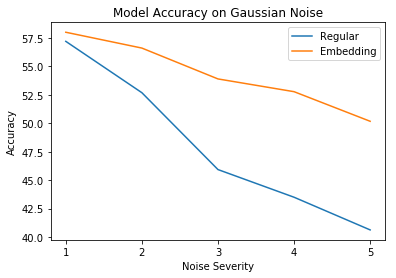

In [57]:
true = [57.19, 52.68, 45.93, 43.5, 40.63]
cool = [57.99, 56.6, 53.89, 52.77, 50.17]

plt.plot(np.r_[1:6], true)
plt.plot(np.r_[1:6], cool)
plt.legend(["Regular", "Embedding"])
plt.title("Model Accuracy on Gaussian Noise")
plt.xlabel("Noise Severity")
plt.xticks(range(1,6))
plt.ylabel("Accuracy")
plt.show()

### Testing on Shot Noise

In [58]:
print("Test accuracy of REGULAR network on SHOT NOISE: {}".format(reg_net.test_model(test_loader, shot_noise)))
print("Test accuracy of EMBEDDED network on SHOT NOISE: {}".format(emb_net.test_model(test_loader, shot_noise)))

Test accuracy of REGULAR network on SHOT NOISE: [59.44, 57.59, 51.77, 47.88, 42.49]
Test accuracy of EMBEDDED network on SHOT NOISE: [58.48, 57.81, 55.65, 54.02, 51.42]


### Testing on Zoom Blur

In [59]:
print("Test accuracy of REGULAR network on ZOOM BLUR: {}".format(reg_net.test_model(test_loader, zoom_blur)))
print("Test accuracy of EMBEDDED network on ZOOM BLUR: {}".format(emb_net.test_model(test_loader, zoom_blur)))

Test accuracy of REGULAR network on ZOOM BLUR: [56.52, 55.69, 53.3, 51.33, 48.21]
Test accuracy of EMBEDDED network on ZOOM BLUR: [53.37, 52.33, 50.88, 49.14, 46.85]


### Inspecting Convolution Weights

In [61]:
weights_reg, bias_reg = deepcopy(reg_net.state_dict()['0.weight']), deepcopy(reg_net.state_dict()['0.bias'])
weights_emb, bias_emb = deepcopy(emb_net.state_dict()['0.weight']), deepcopy(emb_net.state_dict()['0.bias'])

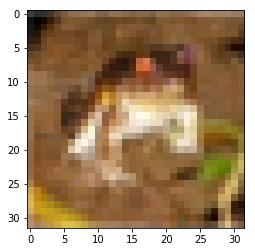

In [62]:
def norm(im):
    im = deepcopy(im)
    im = im - torch.min(im)
    im = im / torch.max(im)
    return im
plt.imshow(train_data[0][0].int().permute(1, 2 ,0))
plt.show()

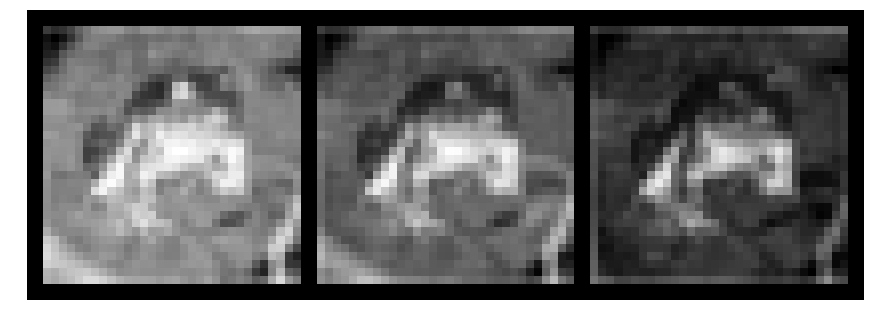

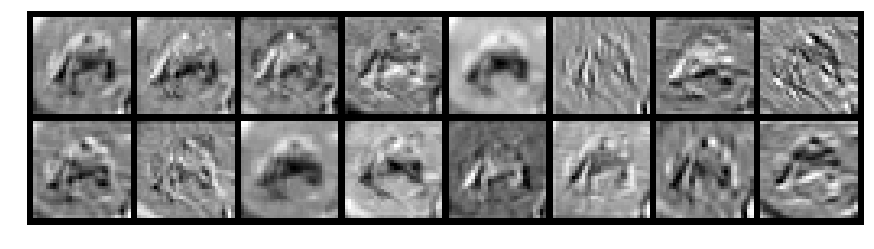

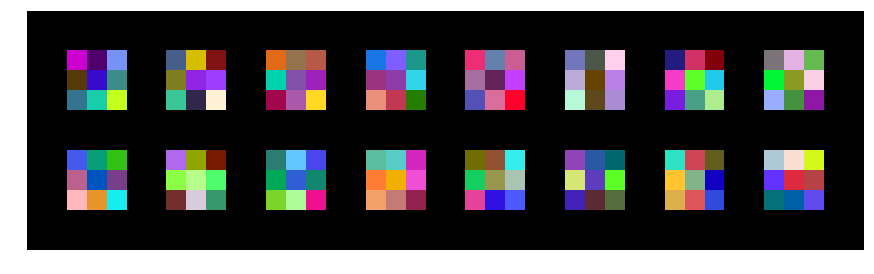

In [63]:
def imshow(img, to_norm=True, figsize=(15, 10)):
    img = deepcopy(img)
    if to_norm:
        img = norm(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
test_im,_ = train_data[0]
test_im = test_im[None,:,:,:]
test_im_reg = F.conv2d(test_im, weight=weights_reg, bias=bias_reg).permute(1,0,2,3)

for i in range(len(weights_reg)):
    weights_reg[i] = norm(weights_reg[i])
    test_im_reg[i] = norm(test_im_reg[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_reg), to_norm=False)
imshow(torchvision.utils.make_grid(weights_reg), to_norm=False)




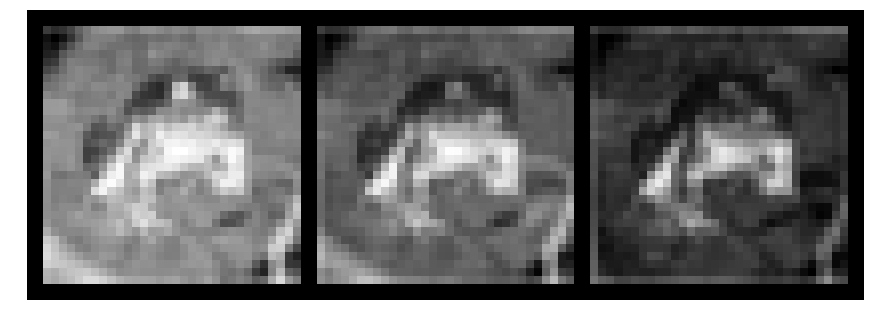

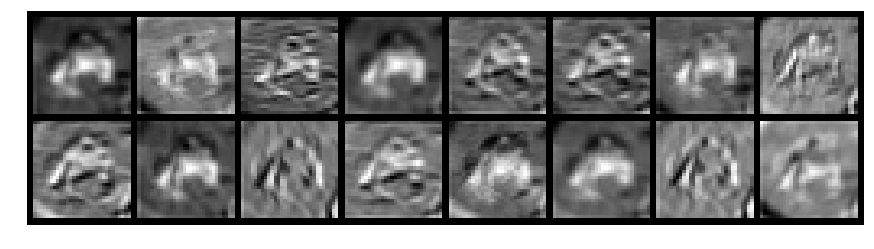

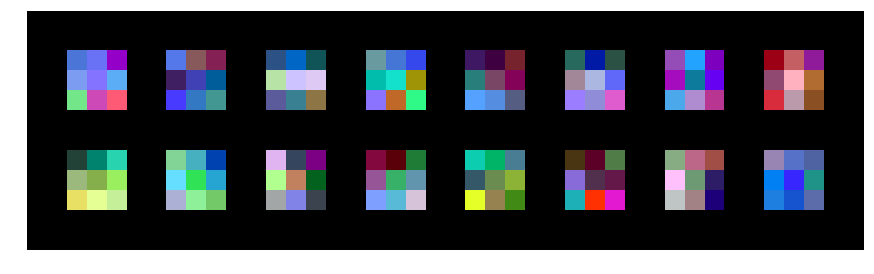

In [64]:
test_im_emb = F.conv2d(test_im, weight=weights_emb, bias=bias_emb).permute(1,0,2,3)

# print(test_im_reg)

for i in range(len(weights_emb)):
    weights_emb[i] = norm(weights_emb[i])
    test_im_emb[i] = norm(test_im_emb[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_emb), to_norm=False)
imshow(torchvision.utils.make_grid(weights_emb), to_norm=False)

In [4]:
resnet_model = resnet18(pretrained=True)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
for param in resnet_model.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
trunc_resnet = nn.Sequential(*list(resnet_model.children())[:-3])

# trunc_resnet

In [33]:
added_module = BaseNetwork1(FlattenLayer(), EmbedLayer(1024, 5000), nn.ReLU(), 
                             nn.Linear(5000, 10))

our_resnet = BaseNetwork1(trunc_resnet, added_module)

our_opt = optim.RMSprop(our_resnet.parameters(), lr=.0005)

In [ ]:
baseline = BaseNetwork1(trunc_resnet, FlattenLayer(), nn.ReLU(), nn.Linear(1024, 10))
base_opt = optim.Adagrad(baseline.parameters(), lr=.005)

In [ ]:
# baseline

In [24]:
baseline.train_model(epochs=5, opt=base_opt, criterion=criterion, train_loader=train_loader)

Training Model


[1,    16] loss: 2.21695
[1,    32] loss: 2.08610
[1,    48] loss: 2.01620
[1,    64] loss: 1.97708
[1,    80] loss: 1.90972
[1,    96] loss: 1.89435
[1,   112] loss: 1.85979
[1,   128] loss: 1.84682
[1,   144] loss: 1.77488
[1,   160] loss: 1.78129
[1,   176] loss: 1.71693
[1,   192] loss: 1.74729
[1,   208] loss: 1.72794
[1,   224] loss: 1.70349
[1,   240] loss: 1.68503
[1,   256] loss: 1.73965
[1,   272] loss: 1.66096
[1,   288] loss: 1.67602
[1,   304] loss: 1.62687
[1,   320] loss: 1.74039
[1,   336] loss: 1.68491
[1,   352] loss: 1.64386
[1,   368] loss: 1.62639
[1,   384] loss: 1.59114
[1,   400] loss: 1.59659
[1,   416] loss: 1.63541
[1,   432] loss: 1.61050
[1,   448] loss: 1.50804
[1,   464] loss: 1.53381
[1,   480] loss: 1.57309
[1,   496] loss: 1.57291
[1,   512] loss: 1.54989
[1,   528] loss: 1.52689
[1,   544] loss: 1.58544
[1,   560] loss: 1.56783
[1,   576] loss: 1.58221
[1,   592] loss: 1.50852
[1,   608] loss: 1.45566
[1,   624] loss: 1.51354
[1,   640] loss: 1.52149


[2,    16] loss: 1.20384
[2,    32] loss: 1.23082
[2,    48] loss: 1.27860
[2,    64] loss: 1.28579
[2,    80] loss: 1.23303
[2,    96] loss: 1.30391
[2,   112] loss: 1.22955
[2,   128] loss: 1.26358
[2,   144] loss: 1.20959
[2,   160] loss: 1.25296
[2,   176] loss: 1.16575
[2,   192] loss: 1.30238
[2,   208] loss: 1.24741
[2,   224] loss: 1.26883
[2,   240] loss: 1.24737
[2,   256] loss: 1.33913
[2,   272] loss: 1.24614
[2,   288] loss: 1.24739
[2,   304] loss: 1.19863
[2,   320] loss: 1.42679
[2,   336] loss: 1.31843
[2,   352] loss: 1.32234
[2,   368] loss: 1.25134
[2,   384] loss: 1.24184
[2,   400] loss: 1.25048
[2,   416] loss: 1.31991
[2,   432] loss: 1.29472
[2,   448] loss: 1.18315
[2,   464] loss: 1.20537
[2,   480] loss: 1.24445
[2,   496] loss: 1.27723
[2,   512] loss: 1.23623
[2,   528] loss: 1.20398
[2,   544] loss: 1.32242
[2,   560] loss: 1.29727
[2,   576] loss: 1.29830
[2,   592] loss: 1.22079
[2,   608] loss: 1.15587
[2,   624] loss: 1.24725
[2,   640] loss: 1.26809


Process Process-12:
Traceback (most recent call last):
Process Process-11:
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)


KeyboardInterrupt: 

  File "/Applications/anaconda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/Applications/anaconda/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/Applications/anaconda/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Applications/anaconda/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(time

In [26]:
baseline.test_model_once(noise_function=None, severity=0, test_loader=test_loader)

62.25

In [34]:
our_resnet.train_model(epochs=5, opt=our_opt, criterion=criterion, train_loader=train_loader)

Training Model


[1,    16] loss: 2.31555
[1,    32] loss: 2.31371
[1,    48] loss: 2.30677
[1,    64] loss: 2.31567
[1,    80] loss: 2.30566
[1,    96] loss: 2.31158
[1,   112] loss: 2.31112
[1,   128] loss: 2.30579
[1,   144] loss: 2.30617
[1,   160] loss: 2.30821
[1,   176] loss: 2.30829
[1,   192] loss: 2.30458
[1,   208] loss: 2.30495
[1,   224] loss: 2.30072
[1,   240] loss: 2.30213
[1,   256] loss: 2.31133
[1,   272] loss: 2.30341
[1,   288] loss: 2.31368
[1,   304] loss: 2.30470
[1,   320] loss: 2.30538
[1,   336] loss: 2.30910
[1,   352] loss: 2.30518


Process Process-21:
Process Process-22:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/Applications/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py"

KeyboardInterrupt: 

In [105]:
for epoch in range(5):
    run_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        base_opt.zero_grad()
        outputs = baseline(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        base_opt.step()
        run_loss += loss.item()
        if i % train_loader.batch_size == train_loader.batch_size - 1:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, run_loss / (train_loader.batch_size)))
            run_loss = 0.0

RuntimeError: size mismatch, m1: [8192 x 2], m2: [1024 x 10] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070